# Planting Fake Multiply-Imaged Transients Around a galaxy

This notebook provides an example of the steps to plant multiple SN images (i.e. PSFs, or "fakes") around a galaxy, pretending the galaxy is a lens, and planting the SNe along a line that intersects the galaxy center.

In [1]:
import astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.stats import sigma_clipped_stats,gaussian_fwhm_to_sigma,gaussian_sigma_to_fwhm
from astropy.table import Table,Column,Row,vstack,setdiff,join
from astropy.nddata import Cutout2D,NDData
import astropy.units as u
import os 
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval,simple_norm
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

import photutils
from photutils.datasets import make_gaussian_sources_image

import numpy as np
import itertools
import copy

import matplotlib
from astropy.visualization import ZScaleInterval,simple_norm
zscale = ZScaleInterval()
import pickle
import numpy as np

In [2]:
import diffimageml
from diffimageml import fakeplanting, util

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Initialize the FakePlanter Class with test data

In [3]:
use_example_dataset = 1  # or 2.

In [4]:
# get one of the two test data-sets provided
exampledata = util.get_example_data()

# initialize the FakePlanter Class 
if use_example_dataset==1:
    fp = fakeplanting.FakePlanter(exampledata['diffim1'],
                                  searchim_fitsfilename=exampledata['searchim1'],
                                  templateim_fitsfilename=exampledata['templateim1'])
else:
    fp = fakeplanting.FakePlanter(exampledata['diffim2'],
                                  searchim_fitsfilename=exampledata['searchim2'],
                                  templateim_fitsfilename=exampledata['templateim2'])
    

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Detecting galaxies
## Selecting one for use with example in this nb 

In [5]:
# Galaxies are identified using cuts on ellipticity/area to remove stars/cosmic rays from detected sources
fp.has_detections = False
fp.templateim.detect_host_galaxies(ellipticity_cut = 0.35 , cut_cr = True, edges = True, nsigma=10)
print("{} galaxies detected in the template".format(len(fp.templateim.hostgalaxies)))

print("For purpose of displaying positions (phi,d) for planting fakes around lensing host, selecting the first galaxy") 
galaxy_idx = 0
host = fp.templateim.hostgalaxies[galaxy_idx]

# Show the properties of the selected galaxy
host["Source Properties"].to_table()

14 galaxies detected in the template
For purpose of displaying positions (phi,d) for planting fakes around lensing host, selecting the first galaxy


id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18,1451.7765800512723,237.56387965912907,None,None,796.417938891407,None,6505.834693151423,361.43526073063464,361.4352063751844,1449.0,1454.0,236.0,239.0,37.773806987282285,52.79837231592393,1452.0,236.0,1453.0,238.0,18.0,2.393653682408596,13.65685424949238,1.5272834622472333,0.8941487972435961,21.132286475561617,0.8107081874714659,0.4145495454210233,1.7080864694505093,2.1333288192139355,0.5155446250829746,0.9987680264521299,0.5355570481094074,-0.5528882588660692,1.1439285748097612,0.050181952713786296


# Create "lensed SN image" locations around the galaxy

Here we are specifying locations for four images of a multiply-imaged SN, using cylindrical coordinates centered on the galaxy center.  The angle, phi is in degrees, and the distance d is in pixels.  The flux values are set to ~1000, which will be easily visible in the LCO example data.

In [6]:
# quad imaged SN
phi_deg = [45,-45,135,-135]
d_pix = [10,10,10,10]
fluxes = [2*10**3,3*10**3,4*10**3,5*10**3]
galaxy_indices = [galaxy_idx for i in range(len(phi_deg))]

print("Setting four locations around the galaxy (all of similar flux will be easily detectable)")

fake_positions_and_fluxes = fp.set_fake_positions_at_galaxies(phi_deg,d_pix,fluxes=fluxes,galaxy_indices=galaxy_indices)
print(fp.templateim.lensed_locations.meta)
fp.templateim.lensed_locations

Setting four locations around the galaxy (all of similar flux will be easily detectable)
{'phi_deg': [45, -45, 135, -135], 'd_pix': [10, 10, 10, 10], 'galaxy_indices': [0, 0, 0, 0], 'delta_x': <Quantity [ 4.04626336,  9.14482109, -9.14482109, -4.04626336]>, 'delta_y': <Quantity [ 9.14482109, -4.04626336,  4.04626336, -9.14482109]>}


x_fit,y_fit,flux_fit
,,
float64,float64,int64
1455.8228434065886,246.70870075412182,2000
1460.921401146265,233.51761630381276,3000
1442.6317589562796,241.61014301444538,4000
1447.730316695956,228.41905856413632,5000


## Show Where the Fakes Will be planted

Visualize the galaxy ellipse and lensed locations around it


Theta (orientation from source_properties) is direction of the galaxy semimajor axis a, CCW with respect to +x
Phi is CCW with respect to the semimajor axis
d is pixels from galaxy centroid


Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


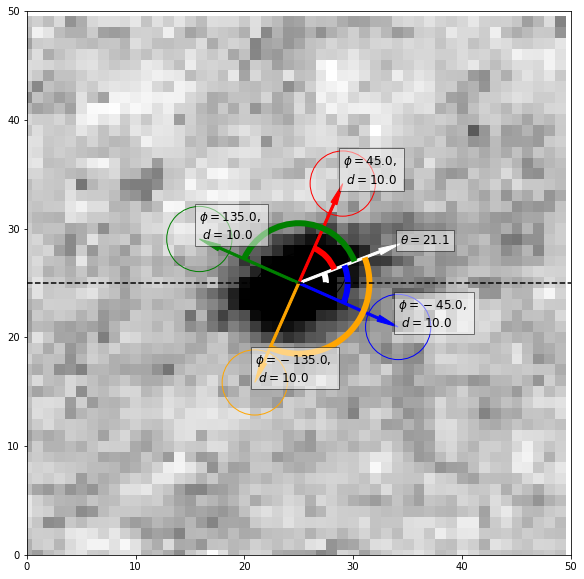

In [7]:
print("Theta (orientation from source_properties) is direction of the galaxy semimajor axis a, CCW with respect to +x")
print("Phi is CCW with respect to the semimajor axis")
print("d is pixels from galaxy centroid")

fp.plot_lensed_locations()

## Plant SNe at the locations

See the example notebook at the readthedocs site for details of building the epsf.

Here we are just using the pre-made ePSF model from the test_data.

In [8]:
build_epsf = pickle.load(open(exampledata['psfmodel1'],"rb"))

# Plant the fakes
fp.plant_fakes_triplet(
    fake_positions_and_fluxes, psfmodel=build_epsf,
    writetodisk=False, save_suffix="planted.fits",preserve_original=False)

print("Fake planting is done.")
assert(fp.diffim.has_fakes==True)
assert(fp.searchim.has_fakes==True)
print("has_fakes is True, True!")

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Fake planting is done.
has_fakes is True, True!


## Display the fakes in the diff image

fake_indices is the SN FKNNN that you want to plot

in this example we generated a single set quadruply-imaged SN, lensed by single lensing galaxy, so they are all visible around one another, and each of the panels just recenters on a different component of the quad.

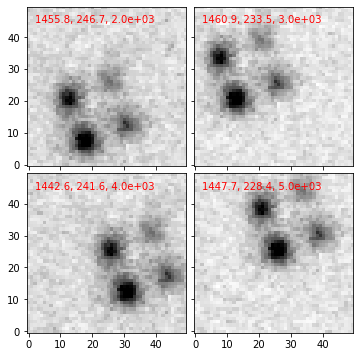

In [9]:
fake_indices=[0,1,2,3]
fp.plot_fakes(
    fake_indices=fake_indices)

# Create "Postage Stamp" Image Cutouts 


Here we generate Multi Extension Fits (MEF) files, with the template/search/diff images each as a separate extension. 

These will lter be converted to PNGs for ingesting into the CNN training/validation functions. 

This example shows the generation of MEFs for all remaining detected galaxies (after planting some more fakes) as well as all detected sources in the diff images (i.e.  false positives)

After completion, the output MEFS will be combined into a tar ball.

In [10]:
"""
Going to use the remainder of the detected galaxies now to plant some more fake SNe
"""
print("{} galaxies detected in the template".format(len(fp.templateim.hostgalaxies)))
print("Recall from above, galaxy_idx = 0, we selected the first galaxy to use for planting our quad-SN demo")
print("We will now also include a single planted SN (solo) around each of the other detected galaxies (setting locations/fluxes at random)")
print('\n')

# We start by concatenating these host galaxies (with random parameters) onto the 
# pre-defined (see above) posflux table of the of the quad SN
hosts = fp.templateim.hostgalaxies[galaxy_idx+1:]
phi_deg = np.concatenate([phi_deg,np.random.uniform(low=0,high=180,size=len(hosts))])
d_pix = np.concatenate([d_pix,np.random.uniform(low=0,high=20,size=len(hosts))])
fluxes = np.concatenate([fluxes,np.random.uniform(low=10**3,high=10**4,size=len(hosts))])
galaxy_indices = np.concatenate([galaxy_indices,[i+1 for i in range(len(hosts))]])

fake_positions_and_fluxes = fp.set_fake_positions_at_galaxies(
    phi_deg,d_pix,fluxes=fluxes,galaxy_indices=galaxy_indices)

# Uncomment to see the randomly selected angles phi and pixel offsets d.
# print(fp.templateim.lensed_locations.meta)

# Show the final table of lensed transient positions + fluxes.
fp.templateim.lensed_locations

14 galaxies detected in the template
Recall from above, galaxy_idx = 0, we selected the first galaxy to use for planting our quad-SN demo
We will now also include a single planted SN (solo) around each of the other detected galaxies (setting locations/fluxes at random)




x_fit,y_fit,flux_fit
,,
float64,float64,float64
1455.8228434065886,246.70870075412182,2000.0
1460.921401146265,233.51761630381276,3000.0
1442.6317589562796,241.61014301444538,4000.0
1447.730316695956,228.41905856413632,5000.0
2100.3118495994117,451.3888956509308,1786.2432882284345
660.6990641979866,598.3618580233953,6004.219087897873
1317.8141168976845,1033.85330019604,6345.327847027576
582.3057798127397,1318.2968742817056,1975.758552390827


In [11]:
# Plant the fakes
fp.plant_fakes_triplet(
    fake_positions_and_fluxes, psfmodel=build_epsf,
    writetodisk=False, save_suffix="planted.fits",preserve_original=False)

print("Fake planting is done.")
assert(fp.diffim.has_fakes==True)
assert(fp.searchim.has_fakes==True)
print("has_fakes is True, True!")

# Create the MEFS for all the fake plants
fake_indices = [i for i in range(len(fake_positions_and_fluxes[0]))]
MEFS = fp.plants_MEF(fake_indices,cutoutsize=50,writetodisk=True)

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Fake planting is done.
has_fakes is True, True!


Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

## Gallery of Fake SNe

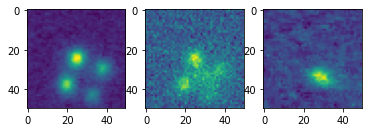

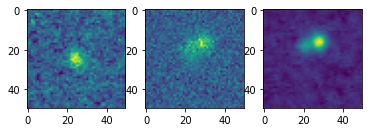

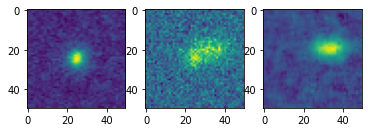

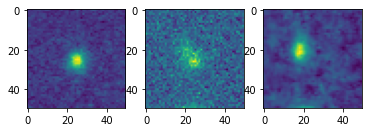

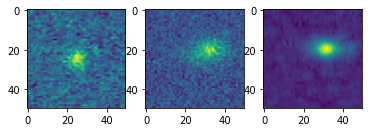

In [20]:
for mef in MEFS[3:8]:
    # This creates a PNG for each image in the triplet, shows it,
    # then closes it.  No saving to disk.  
    fp.png_MEF(mef, show=True, writetodisk=False)

## Find False Positives

Identify false positives in the clean difference image. These are subtraction artifacts, detector defects, cosmic rays, etc. (not true SN-like objects). 

We also make MEFs and PNGs for these--we want the CNNs to learn how to discriminate these from the (fake) multiply-imaged SNe that we've planted elsewhere.

In [12]:
# finding false positives, runs detect_sources on clean difference image
false_positive_MEFS = fp.FP_MEF(cutoutsize=50,writetodisk=True)
print(len(false_positive_MEFS))

Gaia catalog /Users/rodney/Dropbox/src/diffimageml/diffimageml/test_data/sky_image_1_GaiaCat.ecsv exists. 
Reading without fetching.


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:7

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro

162


## Gallery of False Positives

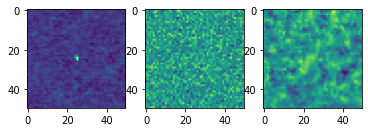

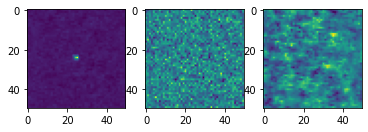

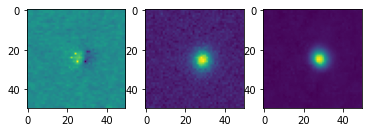

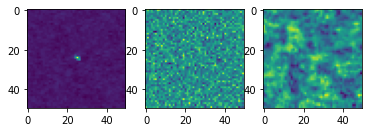

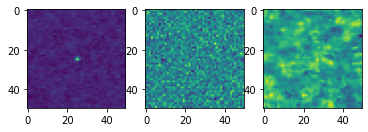

In [15]:
for mef in false_positive_MEFS[0:5]:
    # This creates a PNG for each image in the triplet, shows it,
    # then closes it.  No saving to disk.  
    fp.png_MEF(mef, show=True, writetodisk=False)